In [143]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, MinMaxScaler
from scipy import stats

In [144]:
# Cell 2: Load Data
# Define the path to your data file
data_path = r'C:\Users\derek\OneDrive\Documents\Capstone\steam-indie-success\data\steam_indie_games_balanced.csv'

# Load the data into a DataFrame
df = pd.read_csv(data_path, encoding='utf-8')

# Preview the dataset and explore general properties
print(df.head(10))
print(df.dtypes)
print(df.info())
print(df.describe(include='all'))
print(df.sample(10))

     AppID                             Game Name  Release Date  \
0  2193070                      Returning To Mia  Oct 27, 2023   
1   328940                          The Deer God  Feb 27, 2015   
2  2738050                  エスカレーター |  Escalator   Jan 6, 2024   
3  1634150  Behind the Frame: The Finest Scenery  Aug 25, 2021   
4   391260                         Labyronia RPG  Aug 14, 2015   
5   311400                     OCEAN CITY RACING  Nov 14, 2014   
6  1329600                               Karting  Apr 15, 2021   
7  1245430                          Golden Light  Mar 11, 2022   
8   314180                           Deathsmiles  Mar 10, 2016   
9  2482440              Leap up no Justu: Double  Dec 21, 2023   

                             Developer  \
0                        Inceton games   
1  Crescent Moon Games, Cinopt Studios   
2                              Toyasky   
3                 Silver Lining Studio   
4                         Labyrinthine   
5               OCR D

Missing values:
 AppID                 0
Game Name             0
Release Date          0
Developer             0
Genres                0
Price ($)             0
Recommendations       0
Metacritic Score    255
dtype: int64


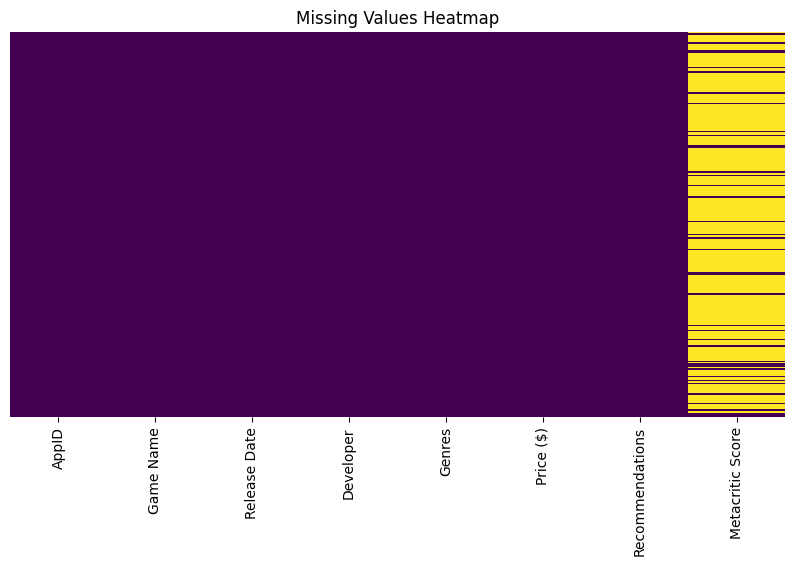

In [145]:
# Cell 3: Check for Missing Values
# Check for missing values
missing_values = df.isna().sum()
print("Missing values:\n", missing_values)

# Visualize missing values
plt.figure(figsize=(10, 5))
sns.heatmap(df.isna(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap')
plt.show()

In [146]:
# Cell 4: Data Cleaning - Dates, Prices, and Text Data
# Step 1: Convert 'Release Date' to datetime
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')
print(f"Number of invalid dates: {df['Release Date'].isna().sum()}")

# Step 2: Convert 'Price ($)' to numeric
df['Price ($)'] = pd.to_numeric(df['Price ($)'].str.replace('$', '', regex=True), errors='coerce')
print(f"Number of invalid price entries: {df['Price ($)'].isna().sum()}")

# Step 3: Handle missing values in 'Metacritic Score' by filling with median
df['Metacritic Score'].fillna(df['Metacritic Score'].median(), inplace=True)

# Step 4: Clean text data (e.g., strip extra whitespace)
for col in ['Game Name', 'Developer', 'Genres']:
    df[col] = df[col].str.strip()

# Display updated missing values
print(df.isna().sum())

Number of invalid dates: 6
Number of invalid price entries: 6
AppID               0
Game Name           0
Release Date        6
Developer           0
Genres              0
Price ($)           6
Recommendations     0
Metacritic Score    0
dtype: int64


C:\Users\derek\AppData\Local\Temp\ipykernel_146820\2978877203.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Metacritic Score'].fillna(df['Metacritic Score'].median(), inplace=True)


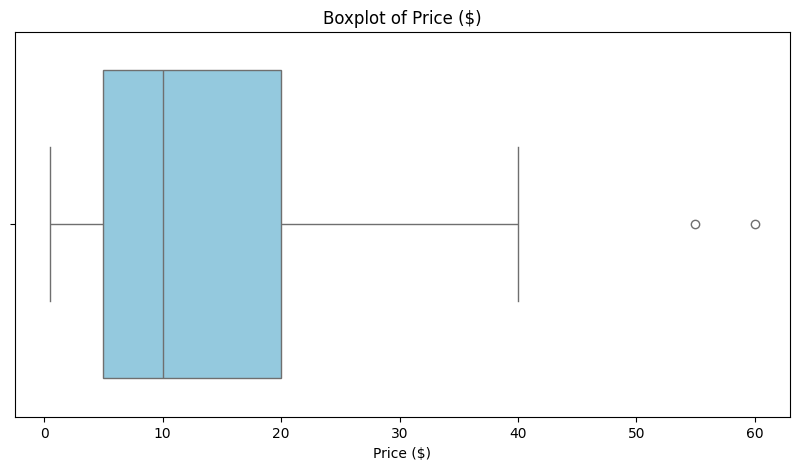

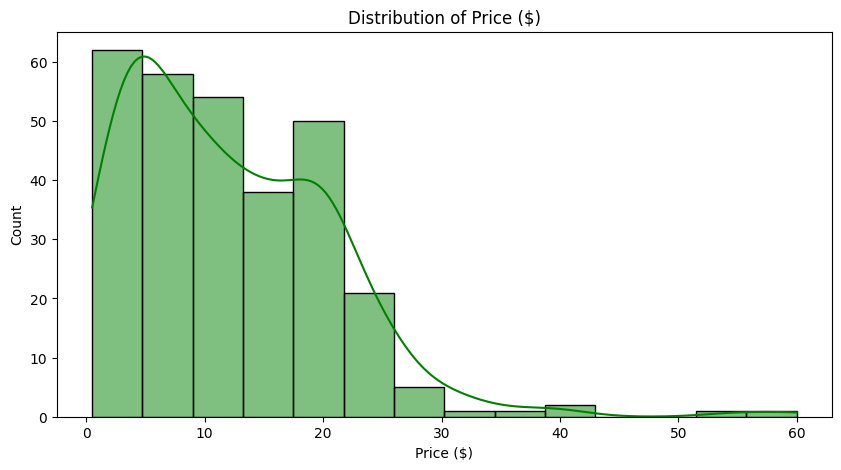

In [147]:
# Cell 5: Boxplot and Histogram for Price
# Boxplot for Price ($)
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='Price ($)', color='skyblue')
plt.title('Boxplot of Price ($)')
plt.xlabel('Price ($)')
plt.show()

# Histogram of Price to visualize distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['Price ($)'], kde=True, color='green')
plt.title('Distribution of Price ($)')
plt.xlabel('Price ($)')
plt.show()

In [148]:
# Cell 6: Identify Outliers for Price
# Calculate IQR for identifying outliers
Q1 = df['Price ($)'].quantile(0.25)
Q3 = df['Price ($)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Finding the outliers
outliers = df[(df['Price ($)'] < lower_bound) | (df['Price ($)'] > upper_bound)]
print("Number of outliers in 'Price ($)':", outliers.shape[0])
print(outliers[['Game Name', 'Price ($)']])

# Document decision to retain or remove outliers
print("Outliers in 'Price ($)' have been retained for further analysis.")

Number of outliers in 'Price ($)': 2
           Game Name  Price ($)
29      Dude Fighter      59.99
176  Legendary Tales      54.99
Outliers in 'Price ($)' have been retained for further analysis.


In [149]:
# Cell 7: Remove Duplicate Rows
# Check for duplicate rows and remove them
print(f"Number of duplicate rows: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Number of rows after removing duplicates: {df.shape[0]}")

Number of duplicate rows: 0
Number of rows after removing duplicates: 300


In [150]:
# Cell 8: Process Genres Column
# Convert the Genres column into a list of genres for each game
df['Genres'] = df['Genres'].apply(lambda x: [genre.strip() for genre in x.split(',')])

# Use MultiLabelBinarizer to create separate columns for each genre
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df['Genres'])

# Create a new DataFrame with the genre columns and add it to the original DataFrame
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_, index=df.index)
df = pd.concat([df, genres_df], axis=1)

# Drop the original 'Genres' column
df.drop('Genres', axis=1, inplace=True)

# Preview the updated DataFrame
print(df.head())

     AppID                             Game Name Release Date  \
0  2193070                      Returning To Mia   2023-10-27   
1   328940                          The Deer God   2015-02-27   
2  2738050                  エスカレーター |  Escalator   2024-01-06   
3  1634150  Behind the Frame: The Finest Scenery   2021-08-25   
4   391260                         Labyronia RPG   2015-08-14   

                             Developer  Price ($)  Recommendations  \
0                        Inceton games      14.99              193   
1  Crescent Moon Games, Cinopt Studios      14.99              220   
2                              Toyasky       2.99              116   
3                 Silver Lining Studio      12.99             4321   
4                         Labyrinthine       1.99             1116   

   Metacritic Score  Action  Adventure  Casual  ...  Indie  \
0              77.0       0          1       1  ...      1   
1              59.0       0          0       0  ...      1   
2 

In [151]:
# Cell 9: Scaling Numerical Features
# Select numerical columns to normalize
num_cols = ['Price ($)', 'Recommendations', 'Metacritic Score']

# Apply MinMaxScaler to normalize the selected columns
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Preview the updated DataFrame
print(df.head())

     AppID                             Game Name Release Date  \
0  2193070                      Returning To Mia   2023-10-27   
1   328940                          The Deer God   2015-02-27   
2  2738050                  エスカレーター |  Escalator   2024-01-06   
3  1634150  Behind the Frame: The Finest Scenery   2021-08-25   
4   391260                         Labyronia RPG   2015-08-14   

                             Developer  Price ($)  Recommendations  \
0                        Inceton games   0.243697         0.000097   
1  Crescent Moon Games, Cinopt Studios   0.243697         0.000125   
2                              Toyasky   0.042017         0.000016   
3                 Silver Lining Studio   0.210084         0.004434   
4                         Labyrinthine   0.025210         0.001066   

   Metacritic Score  Action  Adventure  Casual  ...  Indie  \
0              0.70       0          1       1  ...      1   
1              0.25       0          0       0  ...      1   
2 

In [152]:
# Cell 10: One-Hot Encoding for Developer Column
# One-hot encode the 'Developer' column
developer_counts = df['Developer'].value_counts()
top_developers = developer_counts[developer_counts > 1].index  # Keeping developers with more than 1 game
df['Developer'] = df['Developer'].apply(lambda x: x if x in top_developers else 'Other')

developer_dummies = pd.get_dummies(df['Developer'], prefix='Developer')
df = pd.concat([df, developer_dummies], axis=1)

# Drop the original 'Developer' column
df.drop('Developer', axis=1, inplace=True)

# Confirm the change
print(df.head())

     AppID                             Game Name Release Date  Price ($)  \
0  2193070                      Returning To Mia   2023-10-27   0.243697   
1   328940                          The Deer God   2015-02-27   0.243697   
2  2738050                  エスカレーター |  Escalator   2024-01-06   0.042017   
3  1634150  Behind the Frame: The Finest Scenery   2021-08-25   0.210084   
4   391260                         Labyronia RPG   2015-08-14   0.025210   

   Recommendations  Metacritic Score  Action  Adventure  Casual  Early Access  \
0         0.000097              0.70       0          1       1             0   
1         0.000125              0.25       0          0       0             0   
2         0.000016              0.70       0          1       0             0   
3         0.004434              0.70       0          1       1             0   
4         0.001066              0.70       1          1       0             0   

   ...  Violent  Developer_Alister Software  Developer_B

In [153]:
# Cell 11: Drop Rows with Missing Critical Values
# Drop rows where 'Release Date' or 'Price ($)' are missing
df.dropna(subset=['Release Date', 'Price ($)'], inplace=True)

# Confirm the changes
print(f"Number of rows after dropping missing values: {df.shape[0]}")
print(df.isna().sum())

Number of rows after dropping missing values: 288
AppID                               0
Game Name                           0
Release Date                        0
Price ($)                           0
Recommendations                     0
Metacritic Score                    0
Action                              0
Adventure                           0
Casual                              0
Early Access                        0
Free To Play                        0
Gore                                0
Indie                               0
Massively Multiplayer               0
Nudity                              0
RPG                                 0
Racing                              0
Sexual Content                      0
Simulation                          0
Sports                              0
Strategy                            0
Violent                             0
Developer_Alister Software          0
Developer_BanzaiProject             0
Developer_Choice of Games           0


In [154]:
# Cell 12: Convert Columns to Appropriate Data Types
# Convert 'Recommendations' to int if they are whole numbers
df['Recommendations'] = df['Recommendations'].astype('int64')

# Convert genre columns to boolean
genre_columns = mlb.classes_
for col in genre_columns:
    df[col] = df[col].astype('bool')

# Confirm data types
print("Final data types:")
print(df.dtypes)


Final data types:
AppID                                        int64
Game Name                                   object
Release Date                        datetime64[ns]
Price ($)                                  float64
Recommendations                              int64
Metacritic Score                           float64
Action                                        bool
Adventure                                     bool
Casual                                        bool
Early Access                                  bool
Free To Play                                  bool
Gore                                          bool
Indie                                         bool
Massively Multiplayer                         bool
Nudity                                        bool
RPG                                           bool
Racing                                        bool
Sexual Content                                bool
Simulation                                    bool
Sports       

In [155]:
# Cell 13: Save Cleaned Dataset
# Save cleaned dataset to a CSV file
cleaned_data_path = r'C:\Users\derek\OneDrive\Documents\Capstone\steam-indie-success\data\steam_indie_games_cleaned.csv'
df.to_csv(cleaned_data_path, index=False)

              AppID         Release Date   Price ($)  Recommendations  \
count  2.880000e+02                  288  288.000000       288.000000   
mean   1.200049e+06  2020-01-15 00:50:00    0.189183         0.003472   
min    4.000000e+03  2006-11-29 00:00:00    0.000000         0.000000   
25%    4.478500e+05  2018-03-15 18:00:00    0.075630         0.000000   
50%    1.110370e+06  2020-09-26 12:00:00    0.159664         0.000000   
75%    1.686130e+06  2023-04-04 12:00:00    0.307773         0.000000   
max    3.172860e+06  2024-10-01 00:00:00    1.000000         1.000000   
std    7.726943e+05                  NaN    0.146355         0.058926   

       Metacritic Score  
count        288.000000  
mean           0.688628  
min            0.000000  
25%            0.700000  
50%            0.700000  
75%            0.700000  
max            0.975000  
std            0.096582  


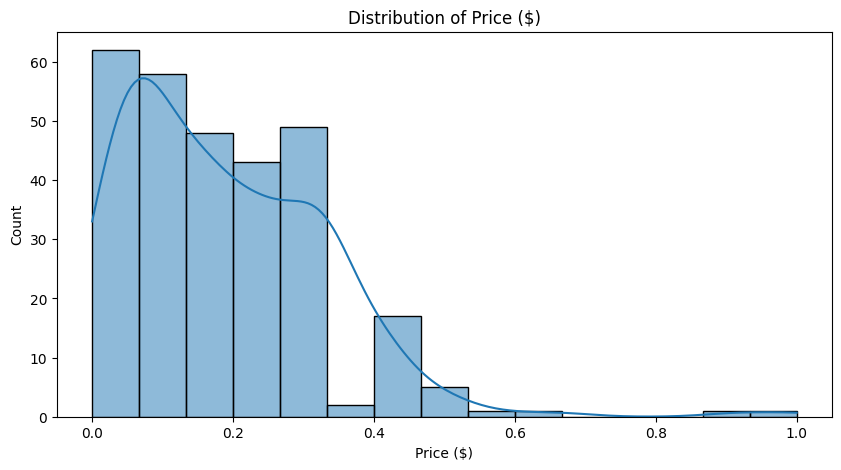

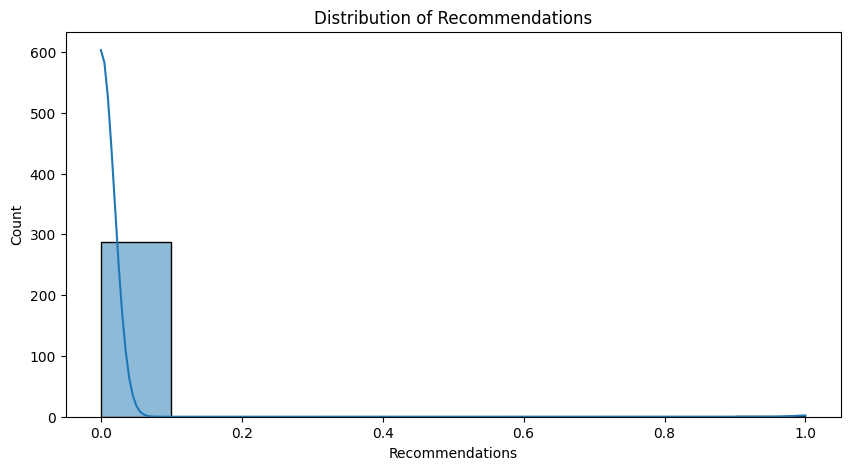

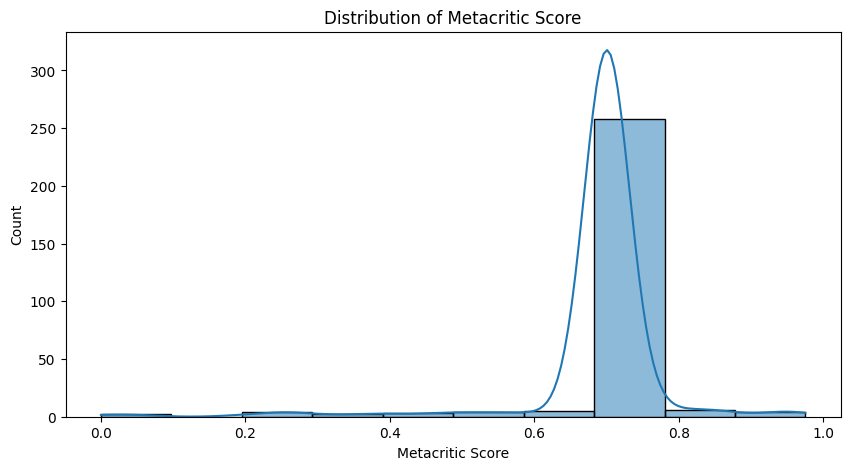

In [156]:
# Cell 14: Summary Statistics and Data Visualization
# Display summary statistics for all numerical columns
print(df.describe())

# Plot histograms for all numerical columns to check for reasonable distributions
for col in num_cols:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.show()

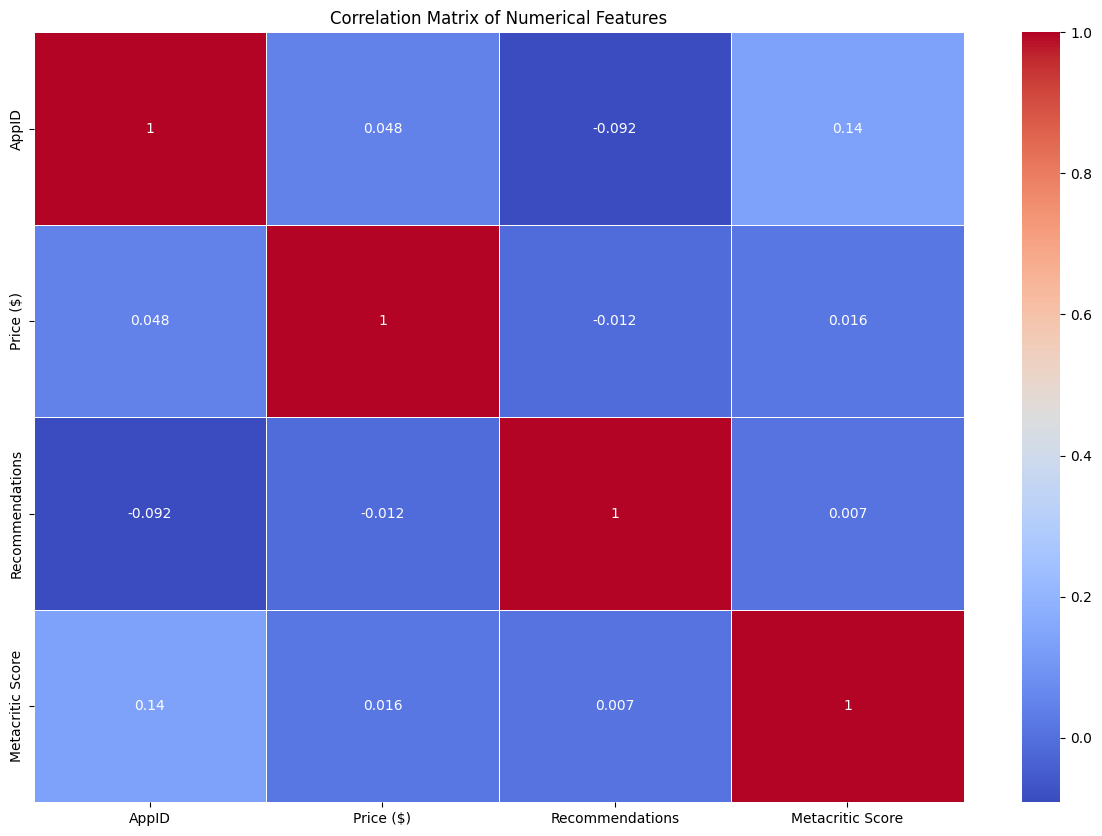

In [157]:
# Cell 15: Correlation Matrix
# Plot the correlation matrix to understand relationships between numerical variables
plt.figure(figsize=(15, 10))

# Select only numeric columns for correlation calculation
numeric_cols = df.select_dtypes(include=['number'])

# Calculate correlation matrix
corr_matrix = numeric_cols.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [158]:
# Cell 16: Final Check for Missing Values and Data Types
# Check for any remaining missing values
print("Final check for missing values:")
print(df.isna().sum())

# Final data type check
print("\nFinal data types:")
print(df.dtypes)


Final check for missing values:
AppID                               0
Game Name                           0
Release Date                        0
Price ($)                           0
Recommendations                     0
Metacritic Score                    0
Action                              0
Adventure                           0
Casual                              0
Early Access                        0
Free To Play                        0
Gore                                0
Indie                               0
Massively Multiplayer               0
Nudity                              0
RPG                                 0
Racing                              0
Sexual Content                      0
Simulation                          0
Sports                              0
Strategy                            0
Violent                             0
Developer_Alister Software          0
Developer_BanzaiProject             0
Developer_Choice of Games           0
Developer_Daedalic

Consider removing metacritic score column as they have very little value and most rows don't have this score. 